In [ ]:
!pip install fastai --upgrade


In [1]:
from fastai import *
from fastai.tabular import *

In [2]:
import math

In [3]:
input_path = './'
train_df = pd.read_csv(f'{input_path}train.csv')
test_df = pd.read_csv(f'{input_path}test.csv')

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
for df in [train_df, test_df]:
    df['Title'] = df['Name'].str.split(',').str[1].str.split(' ').str[1]
    df['Deck'] = df['Cabin'].str[0]

In [8]:
all_df = pd.concat([train_df, test_df], sort=False)
mean_age_by_title = all_df.groupby(['Title', 'Sex', 'Pclass', 'Parch']).mean()['Age']

In [9]:
mean_age_by_title

Title  Sex     Pclass  Parch
Capt.  male    1       1        70.000000
Col.   male    1       0        54.000000
Don.   male    1       0        40.000000
Dona.  female  1       0        39.000000
Dr.    female  1       0        49.000000
                                  ...    
Ms.    female  3       0        23.720000
Rev.   male    2       0        45.333333
                       1        29.000000
Sir.   male    1       0        49.000000
the    female  1       0        33.000000
Name: Age, Length: 67, dtype: float64

In [10]:
for df in [train_df, test_df]:
    for cat, age in mean_age_by_title.iteritems():
        if math.isnan(age):
            print(cat)
            print(age)
        df.loc[df['Age'].isnull() & 
               (df['Title'] == cat[0]) & 
               (df['Sex'] == cat[1]) & 
               (df['Pclass'] == cat[2]) & 
               (df['Parch'] == cat[3]), 'Age'] = age
        
        
        

In [11]:
mean_fare_by_title = all_df.groupby('Title').mean()['Fare']

In [12]:
mean_fare_by_title

Title
Capt.         71.000000
Col.          79.518750
Don.          27.720800
Dona.        108.900000
Dr.           53.254687
Jonkheer.      0.000000
Lady.         39.600000
Major.        28.525000
Master.       36.008195
Miss.         42.684873
Mlle.         59.402100
Mme.          69.300000
Mr.           24.796185
Mrs.          50.560723
Ms.           10.375000
Rev.          18.609375
Sir.          56.929200
the           86.500000
Name: Fare, dtype: float64

In [13]:
for df in [train_df, test_df]:
    for cat, fare in mean_fare_by_title.iteritems():
        df.loc[df['Fare'].isnull() & (df['Title'] == cat), 'Fare'] = fare

In [14]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'Deck']
cont_names = ['Age', 'Fare', 'SibSp', 'Parch']
procs = [FillMissing, Categorify, Normalize]

test = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
data = (TabularList.from_df(train_df, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(0,200)))
                           .label_from_df(cols=dep_var)
                           .add_test(test, label=0)
                           .databunch())

In [15]:
np.random.seed(101)
learn = tabular_learner(data, layers=[60, 20], metrics=accuracy)
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.650393,0.699395,0.360000,00:00
1,0.598697,0.654059,0.720000,00:00
2,0.543853,0.580218,0.770000,00:00
3,0.500279,0.498224,0.815000,00:00
4,0.474088,0.448343,0.825000,00:00


In [16]:
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.405686,0.436638,0.810000,00:00
1,0.406351,0.433361,0.810000,00:00
2,0.400843,0.408105,0.830000,00:00
3,0.389763,0.426050,0.820000,00:00
4,0.390824,0.402237,0.845000,00:00


In [30]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

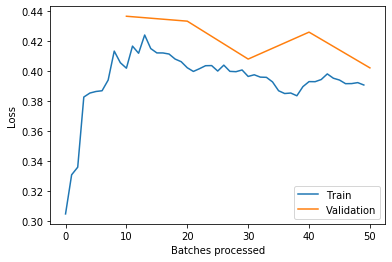

In [38]:
learn.recorder.plot_losses()

In [26]:
interp = ClassificationInterpretation(learn, predictions, y, losses)

NameError: name 'losses' is not defined

In [303]:
sub_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': labels})
sub_df.to_csv('submission.csv', index=False)

In [304]:
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [278]:
from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = f'<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    return HTML(html)

In [279]:
create_download_link(sub_df)